# Time Series Analysis with Recurrent Neural Networks (Keras)

1. Get Data
2. Explore Data
3. Clean and prepare data
4. Split into training and testing sets
5. Assemble Model
6. Train Model
7. Evaluate Model
8. Profit?

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6139655443110324033
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8276421511012624037
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


## 1. Get Data

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import math

df = pd.read_csv('../Historical Data/XOM.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12612.000000,12612.000000,12612.000000,12612.000000,12612.000000,1.261200e+04
mean,34.427807,34.736840,34.117571,34.438288,22.417428,9.861024e+06
std,32.104100,32.367123,31.838445,32.113872,26.479900,9.082650e+06
min,1.714844,1.761719,1.714844,1.714844,0.023546,3.828000e+05
25%,4.460938,4.492188,4.412110,4.458985,0.114427,3.767900e+06
50%,17.781250,17.890625,17.671875,17.812500,6.380258,7.158900e+06
75%,67.305002,68.010000,66.582501,67.389999,46.125944,1.274300e+07
max,104.419998,104.760002,103.949997,104.379997,80.456619,1.180235e+08


In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12612 entries, 0 to 12611
Data columns (total 7 columns):
Date         12612 non-null object
Open         12612 non-null float64
High         12612 non-null float64
Low          12612 non-null float64
Close        12612 non-null float64
Adj Close    12612 non-null float64
Volume       12612 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 689.8+ KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-08-13,1.957031,1.957031,1.921875,1.925781,0.023546,2828800
1,1970-08-14,1.925781,1.949219,1.921875,1.941406,0.023737,2867200
2,1970-08-17,1.941406,1.957031,1.941406,1.953125,0.023880,768000
3,1970-08-18,1.953125,1.996094,1.953125,1.992188,0.024358,1558400
4,1970-08-19,2.000000,2.062500,2.000000,2.054688,0.025122,4928000


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12607,2020-08-06,43.400002,43.900002,43.250000,43.639999,42.795731,14434900
12608,2020-08-07,43.230000,43.520000,42.810001,43.439999,42.599598,18749700
12609,2020-08-10,43.990002,44.599998,43.599998,44.509998,43.648899,24367800
12610,2020-08-11,45.500000,46.419998,44.730000,44.970001,44.100002,28987500
12611,2020-08-12,44.459999,44.939999,43.630001,44.090000,44.090000,22503200


## 2. Explore Data

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


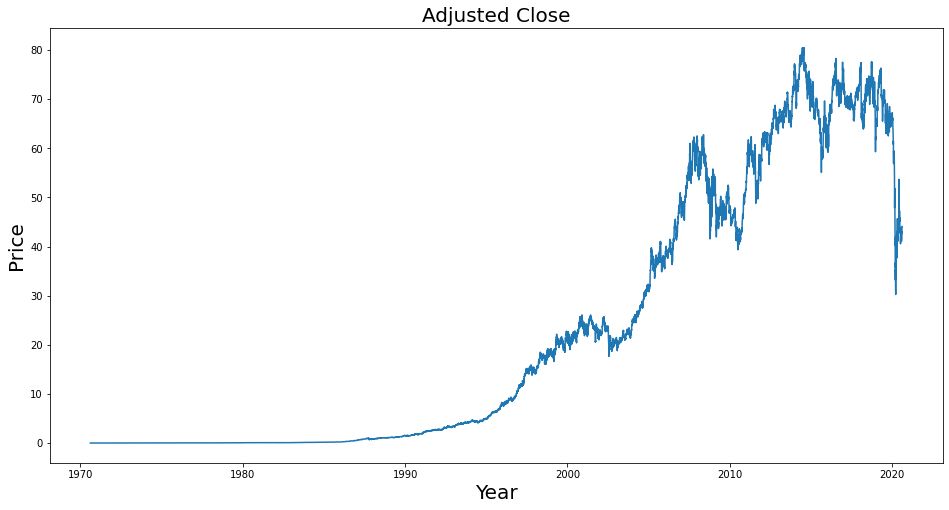

In [8]:
df['Date'] = pd.to_datetime(df['Date']) 
x = df.Date
Y = df['Adj Close']

plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close',fontsize=20)
plt.show()


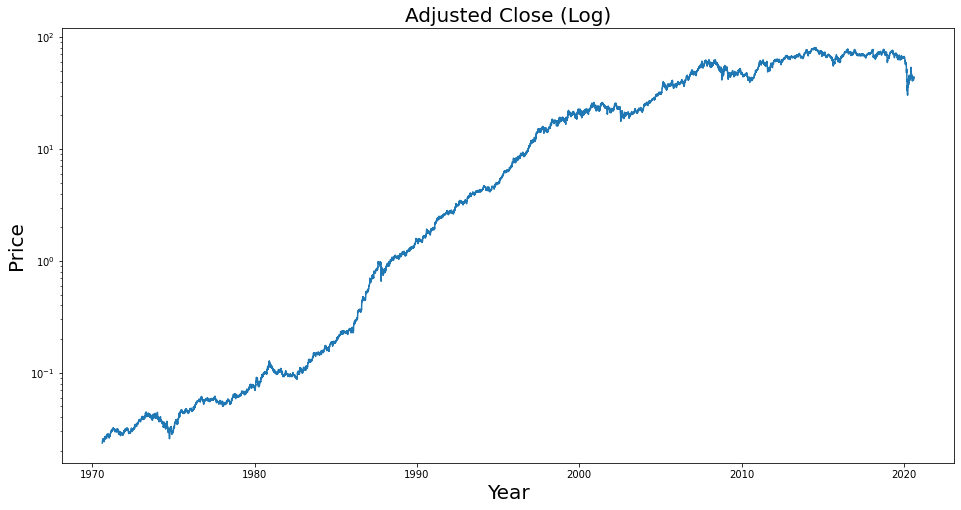

In [9]:
plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close (Log)',fontsize=20)
plt.yscale('log')
plt.show()

In [10]:
df['Adj High'] = (df['Adj Close']/df['Close'])*df['High']
df['Adj Low'] = (df['Adj Close']/df['Close'])*df['Low']
df['Adj Volume'] = df['Volume']

data=df[['Adj Close','Adj Volume','Adj High','Adj Low']]
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low
0,0.023546,2828800,0.023928,0.023498
1,0.023737,2867200,0.023833,0.023498
2,0.023880,768000,0.023928,0.023737
3,0.024358,1558400,0.024406,0.023880
4,0.025122,4928000,0.025218,0.024453


## 3. Clean and Prepare Data

In [11]:
dataCopy = data.copy()

data.loc[:,('dailyReturn')] = np.log(dataCopy.loc[:,('Adj Close')]/dataCopy.loc[:,('Adj Close')].shift(1))
data.loc[:,'weeklyReturn'] = np.log(dataCopy.loc[:,'Adj Close']/dataCopy.loc[:,'Adj Close'].shift(5))
data.loc[:,'dailyHL'] = np.log(dataCopy.loc[:,'Adj High']/dataCopy['Adj Low'])
data.loc[:,'weeklyHL'] = np.log(dataCopy.loc[:,'Adj High'].rolling(6).max()/dataCopy.loc[:,'Adj Low'].rolling(6).min())
data.head(12)

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
0,0.023546,2828800,0.023928,0.023498,NaN,NaN,0.018127,NaN
1,0.023737,2867200,0.023833,0.023498,0.008079,NaN,0.014128,NaN
2,0.023880,768000,0.023928,0.023737,0.006006,NaN,0.008016,NaN
3,0.024358,1558400,0.024406,0.023880,0.019819,NaN,0.021762,NaN
4,0.025122,4928000,0.025218,0.024453,0.030884,NaN,0.030772,NaN
5,0.024931,2262400,0.025170,0.024644,-0.007632,0.057156,0.021094,0.070615
6,0.025409,3811200,0.025457,0.025075,0.018991,0.068068,0.015123,0.080057
7,0.025600,4243200,0.025887,0.025313,0.007489,0.069551,0.022389,0.086701
8,0.025361,2841600,0.025504,0.025027,-0.009380,0.040352,0.018904,0.080667
9,0.025313,3043200,0.025409,0.025217,-0.001894,0.007574,0.007547,0.056957


In [12]:
data = data.dropna(how='any')
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
5,0.024931,2262400,0.025170,0.024644,-0.007632,0.057156,0.021094,0.070615
6,0.025409,3811200,0.025457,0.025075,0.018991,0.068068,0.015123,0.080057
7,0.025600,4243200,0.025887,0.025313,0.007489,0.069551,0.022389,0.086701
8,0.025361,2841600,0.025504,0.025027,-0.009380,0.040352,0.018904,0.080667
9,0.025313,3043200,0.025409,0.025217,-0.001894,0.007574,0.007547,0.056957


In [13]:
def toTimeSeries(df,columns,n_trail=1,n_lead=1):
    df = df[columns]
    n_columns=len(columns)
    cols=[]
    names=[]
    
    # Create trailing columns
    for i in range(n_trail,0,-1):
        cols.append(df.shift(i))
        names += [(columns[j]+'(t-%d)'%(i))  for j in range(n_columns)]
        
    # Create leading columns
    for i in range(0,n_lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j]+'(t+%d)'%(i))  for j in range(n_columns)]
        
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    # Clean up NaN rows
    agg.dropna(inplace=True)
    
    return agg

In [14]:
n_trail = 5
n_lead = 5
columns = ['dailyReturn','weeklyReturn','dailyHL','weeklyHL']

reframed = toTimeSeries(data,columns,n_trail,n_lead)
print(reframed.head())

    dailyReturn(t-5)  weeklyReturn(t-5)  dailyHL(t-5)  weeklyHL(t-5)  \
10         -0.007632           0.057156      0.021094       0.070615   
11          0.018991           0.068068      0.015123       0.080057   
12          0.007489           0.069551      0.022389       0.086701   
13         -0.009380           0.040352      0.018904       0.080667   
14         -0.001894           0.007574      0.007547       0.056957   

    dailyReturn(t-4)  weeklyReturn(t-4)  dailyHL(t-4)  weeklyHL(t-4)  \
10          0.018991           0.068068      0.015123       0.080057   
11          0.007489           0.069551      0.022389       0.086701   
12         -0.009380           0.040352      0.018904       0.080667   
13         -0.001894           0.007574      0.007547       0.056957   
14         -0.007574           0.007632      0.011386       0.049173   

    dailyReturn(t-3)  weeklyReturn(t-3)  ...  dailyHL(t+3)  weeklyHL(t+3)  \
10          0.007489           0.069551  ...      0.00955

## 4. Split in Training and Testing Data

In [15]:
values = reframed.values

trainTestSplit = 0.75

mask = np.random.rand(len(values)) < trainTestSplit

train = values[mask,:]
test = values[~mask,:]
print(train.shape)

# Number of features
n_columns = len(columns)
n_features = (n_lead - 1) * n_columns
n_periods = n_trail + 1

# Number of periods in observation
n_obs = n_periods * n_columns

# Assign test and training sets
X_train, Y_train = train[:,0:n_obs], train[:,-n_features:]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))

X_test, Y_test = test[:,0:n_obs], test[:,-n_features:]
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

new_train = []
for i, train in enumerate(Y_train):
    new_train.append(Y_train[i][-n_columns:].tolist())
Y_train = np.array(new_train)

new_test = []
for i, test in enumerate(Y_test):
    new_test.append(Y_test[i][-n_columns:].tolist())
Y_test = np.array(new_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(9431, 44)
(9431, 24)
(9431, 6, 4) (9431, 16) (3166, 6, 4) (3166, 16)
(9431, 6, 4) (9431, 4) (3166, 6, 4) (3166, 4)


## 5. Assemble the Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1:])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(len(columns)))
    model.compile(loss='mae',optimizer='Adam')

Using TensorFlow backend.


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0

In [17]:
print(model.summary())
model.get_config()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 50)             11000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 6, 4),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

## 6. Train the Model

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Train on 9431 samples, validate on 3166 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_3622 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_3926 in 

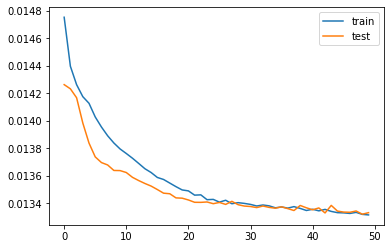

In [18]:
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. Evaluate the Model

In [19]:
Y_predicted = model.predict(X_test)
results = pd.DataFrame(Y_test)
col1, col2, col3, col4 = [],[],[],[]

for pred in Y_predicted:
    col1.append(pred[0])
    col2.append(pred[1])
    col3.append(pred[2])
    col4.append(pred[3])

results[2], results[3], results[4], results[5] = col1, col2, col3, col4
results.columns = ['Daily Return','Weekly Return','Predicted Daily', 'Predicted Weekly', 
                   'Daily HL', 'Weekly HL']
results.head()

Executing op __inference_keras_scratch_graph_39214 in device /job:localhost/replica:0/task:0/device:GPU:0


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL
0,0.022677,0.013172,-0.001020,0.001328,0.015217,0.040902
1,0.017291,0.003803,0.000338,0.001335,0.014444,0.037547
2,-0.009556,0.001938,-0.000413,0.001944,0.014922,0.040380
3,-0.021448,-0.023343,-0.000601,0.002281,0.015694,0.044043
4,0.029197,0.011560,-0.000351,0.001701,0.015121,0.041478


In [20]:
results['Prop'] = results['Weekly Return']/results['Predicted Weekly']

results['Correct'] = results['Prop'].apply(lambda x : 1 if x > 0.5 and x < 2 else 0)
results['Correct2'] = (results['Weekly Return']*results['Predicted Weekly']).apply(lambda x : 1 if x > 0 else 0)

print('Direction and Magnitude Accuracy Score: ', results.Correct.sum()/results.Correct.count())
print('Direction Only Accuracy Score: ', results.Correct2.sum()/results.Correct2.count())

Direction and Magnitude Accuracy Score:  0.03979785217940619
Direction Only Accuracy Score:  0.5296904611497157


In [21]:
np.corrcoef(results['Weekly Return'], results['Predicted Weekly'])

array([[1.        , 0.14724115],
       [0.14724115, 1.        ]])

In [22]:
results['Risk-Reward'] = results['Predicted Weekly']/results['Weekly HL']
analyze = results.copy(deep=True)

buySignal = analyze['Risk-Reward'].quantile(0.95)
sellSignal = analyze['Risk-Reward'].quantile(0.05)

print('Buy Signal: ', buySignal)
print('Sell Signal: ', sellSignal)

Buy Signal:  0.11171258638456565
Sell Signal:  -0.04556569084066418


In [23]:
analyze = analyze[(analyze['Risk-Reward'] > buySignal) | (analyze['Risk-Reward'] <= sellSignal)]
print('Trade Signal x% of the time: ', analyze.shape[0]/results.shape[0])
analyze.head()

Trade Signal x% of the time:  0.10044219835754896


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL,Prop,Correct,Correct2,Risk-Reward
7,-0.001884,-0.051227,-0.000200,-0.002078,0.014990,0.041092,24.650102,0,1,-0.050573
9,-0.025377,0.020376,0.000223,0.006147,0.016563,0.048554,3.314871,0,1,0.126598
10,0.012612,-0.001800,-0.000452,-0.002094,0.016154,0.044023,0.859331,1,1,-0.047568
24,-0.001717,-0.013797,-0.000326,-0.001680,0.013118,0.034314,8.211198,0,1,-0.048967
29,0.014227,0.005307,-0.000214,-0.002175,0.013662,0.036085,-2.439735,0,0,-0.060281


In [24]:
import sklearn
from sklearn.linear_model import LinearRegression

X = analyze['Risk-Reward']
Y = analyze['Weekly Return']

X = np.array(X).reshape(len(X),1)
Y = np.array(Y).reshape(len(Y),1)

lr = LinearRegression()
lr = lr.fit(X,Y)
preds = lr.predict(X)

from sklearn.metrics import r2_score

print('R^2 Score: ', r2_score(Y,preds))

R^2 Score:  0.04841336011044983


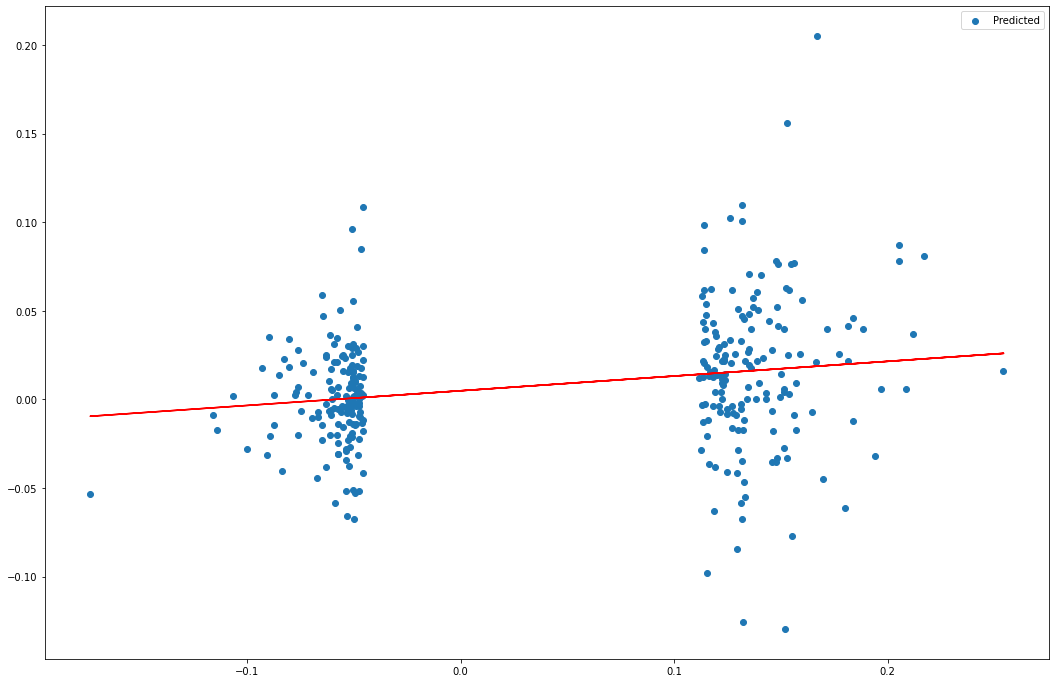

In [25]:
plt.figure(figsize=(18,12))
time = list(range(0,len(X)))
plt.scatter(X,Y,label='Predicted')
plt.plot(X,preds,color='r')
plt.legend()
plt.show()

## 8. Profit?

In [26]:
portfolio = [1000]
hodl = [1000]
bpFee = 20
feeModifier = 1 - (bpFee / 10000)

predicted = results['Predicted Weekly'].tolist()
actual = results['Weekly Return'].tolist()
riskReward = results['Risk-Reward'].tolist()

for prediction in riskReward:
    idx = riskReward.index(prediction)
    if prediction > buySignal:
        today = np.exp(actual[idx])*(portfolio[-1]*feeModifier)
    elif prediction < sellSignal:
        today = np.exp(-actual[idx])*(portfolio[-1]*feeModifier)
    else:
        today = portfolio[-1]
    portfolio.append(today)
    
    hodl.append(np.exp(actual[idx])*hodl[-1])
    
print('Annualized Return: ', ((((portfolio[-1]-1000)/1000)+1)**(52/len(portfolio))-1)*100,'%')

Annualized Return:  3.000476082279424 %


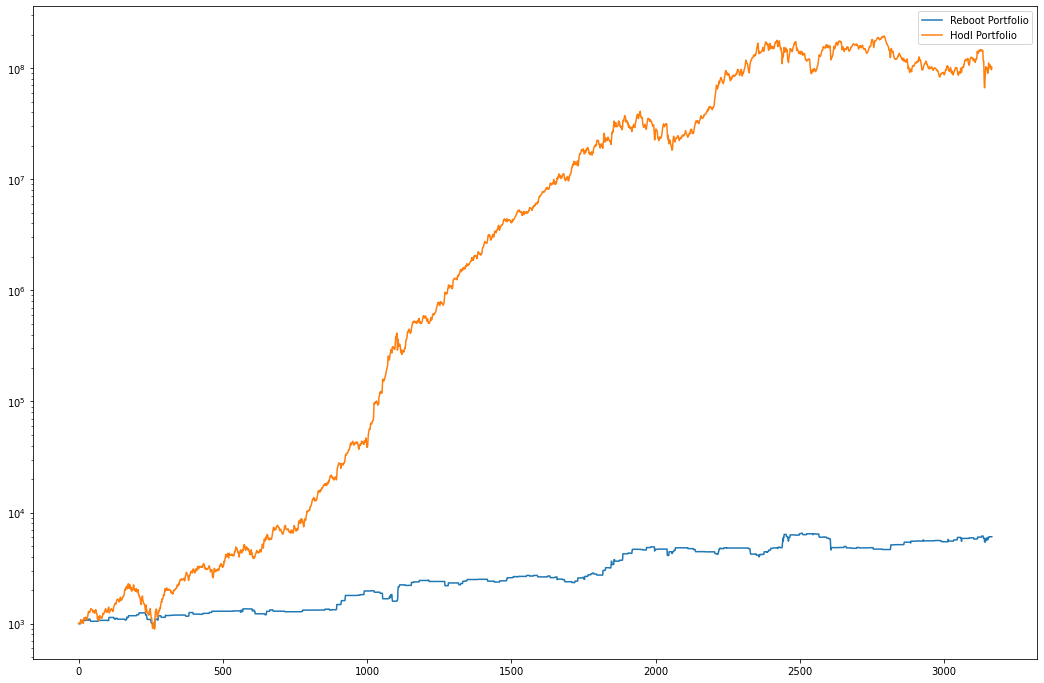

In [27]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.yscale('log')
plt.show()

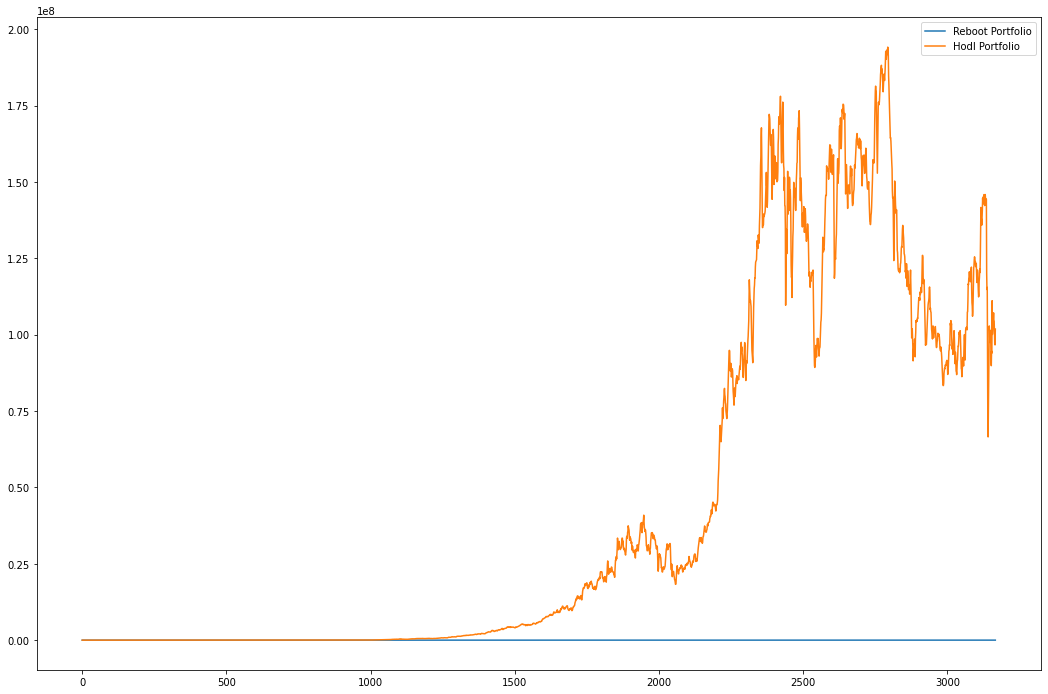

In [28]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.show()

In [29]:
port_df = pd.DataFrame(portfolio,index=time,columns=['portfolio'])
port_df['hodl'] = hodl
port_df['symbol'] = 'XOM'
date_list = df[::4].head(port_df.shape[0]).Date.tolist()
port_df = port_df.head(len(df[::4].Date.tolist()))
port_df['Date'] = df[::4].Date.tolist()
port_df = port_df[['Date','portfolio','hodl','symbol']]
port_df.to_csv('../Results Data/XOM_results.csv',index=False)
port_df

,Date,portfolio,hodl,symbol
0,1970-08-13,1000.000000,1.000000e+03,XOM
1,1970-08-19,1000.000000,1.013259e+03,XOM
2,1970-08-25,1000.000000,1.017120e+03,XOM
3,1970-08-31,1000.000000,1.019094e+03,XOM
4,1970-09-04,1000.000000,9.955811e+02,XOM
...,...,...,...,...
3148,2020-07-16,5855.273194,1.014555e+08,XOM
3149,2020-07-22,5855.273194,1.000867e+08,XOM
3150,2020-07-28,5855.273194,9.977507e+07,XOM
3151,2020-08-03,5855.273194,9.248010e+07,XOM


In [30]:
port_df

,Date,portfolio,hodl,symbol
0,1970-08-13,1000.000000,1.000000e+03,XOM
1,1970-08-19,1000.000000,1.013259e+03,XOM
2,1970-08-25,1000.000000,1.017120e+03,XOM
3,1970-08-31,1000.000000,1.019094e+03,XOM
4,1970-09-04,1000.000000,9.955811e+02,XOM
...,...,...,...,...
3148,2020-07-16,5855.273194,1.014555e+08,XOM
3149,2020-07-22,5855.273194,1.000867e+08,XOM
3150,2020-07-28,5855.273194,9.977507e+07,XOM
3151,2020-08-03,5855.273194,9.248010e+07,XOM


In [31]:
df[::4]

,Date,Open,High,Low,Close,Adj Close,Volume,Adj High,Adj Low,Adj Volume
0,1970-08-13,1.957031,1.957031,1.921875,1.925781,0.023546,2828800,0.023928,0.023498,2828800
4,1970-08-19,2.000000,2.062500,2.000000,2.054688,0.025122,4928000,0.025218,0.024453,4928000
8,1970-08-25,2.085938,2.085938,2.046875,2.074219,0.025361,2841600,0.025504,0.025027,2841600
12,1970-08-31,2.066406,2.066406,2.039063,2.058594,0.025170,1078400,0.025266,0.024931,1078400
16,1970-09-04,2.046875,2.101563,2.046875,2.093750,0.025600,2054400,0.025696,0.025027,2054400
...,...,...,...,...,...,...,...,...,...,...
12592,2020-07-16,44.310001,44.810001,43.790001,44.279999,43.423347,14673700,43.943095,42.942829,14673700
12596,2020-07-22,44.150002,44.150002,43.369999,43.610001,42.766312,21345400,43.295866,42.530953,21345400
12600,2020-07-28,43.910000,44.250000,43.459999,43.549999,42.707470,19190500,43.393929,42.619211,19190500
12604,2020-08-03,42.049999,42.500000,41.470001,42.250000,41.432621,23033600,41.677784,40.667712,23033600
